In [1]:
import os
import sys
import numpy as np
import swyft
import pickle
import matplotlib.pyplot as plt
import torch
import importlib
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
torch.set_float32_matmul_precision('medium')
device_notebook = "cuda" if torch.cuda.is_available() else "cpu"
import wandb
import copy
from torch.multiprocessing import Pool
torch.multiprocessing.set_start_method('spawn',force=True)
torch.set_num_threads(28)
import itertools
import subprocess
from tqdm.auto import tqdm
sys.path.append('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim') 
from explim_functions import generate_expected_limits
import sympy as sy
from scipy.stats import lognorm, norm
import matplotlib.gridspec as gridspec
import random

In [2]:
main_dir = "ALPs_with_SWYFT"
thesis_figs = os.getcwd().split(main_dir)[0]+"/"+main_dir+"/thesis_figures/"

In [3]:
names = ['flare0_informed',]
colors_priors = ['r','#FFA500','y','g','b', ]

priors = {}
for ip, name in enumerate(names):

    priors[name] = {'name': name}

    priors[name]['results_path'] = '/home/gertwk/ALPs_with_SWYFT/cluster_runs/analysis_results/'+name

    priors[name]['store_path'] = priors[name]['results_path']+"/sim_output/store"

    priors[name]['config_vars'] = priors[name]['results_path'] +'/config_variables.pickle'

    priors[name]['config_phys'] = priors[name]['results_path'] +'/physics_variables.pickle'
    
    priors[name]['truncation_record'] = priors[name]['results_path'] +'/truncation_record.pickle'

    removed_ALP_sim=0
    try:
        sys.path.remove('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')
        removed_ALP_sim=1
    except ValueError:
        pass
    try:
        del sys.modules['ALP_quick_sim']
    except KeyError:
        pass
    sys.path.append(priors[name]['results_path'])
    import param_function
    import ALP_quick_sim
    with open(priors[name]['config_vars'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    with open(priors[name]['config_phys'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    with open(priors[name]['truncation_record'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    sys.path.remove(priors[name]['results_path'])
    sys.path.append(priors[name]['results_path']+'/train_output/net')
    import network
    sys.path.remove(priors[name]['results_path']+'/train_output/net')
    
    count = 0
    for combo in itertools.product(*priors[name]['hyperparams'].values()):
        if count == priors[name]['which_grid_point']:
            hyperparams_point = {}
            for i, key in enumerate(priors[name]['hyperparams'].keys()):
                hyperparams_point[key]=combo[i]
        count +=1

    priors[name]['net_path'] = {}
    priors[name]['net'] = {}
    for rnd in range(priors[name]['which_truncation']+1):
        round = 'round_'+str(rnd)
        priors[name]['net_path'][round] = (priors[name]['results_path'] + '/train_output/net/trained_network_'
                                                         +round+'_gridpoint_'+str(priors[name]['which_grid_point'])+'.pt')
        priors[name]['net'][round] = network.NetworkCorner(
            nbins=priors[name]['A'].nbins,
            marginals=priors[name]['POI_indices'],
            param_names=priors[name]['A'].param_names,
            **hyperparams_point,
        )
        priors[name]['net'][round].load_state_dict(torch.load(priors[name]['net_path'][round]))

    with open(priors[name]['results_path']+'/explim_predictions.pickle', 'rb') as file:
        priors[name]['predictions'] = pickle.load(file)

    if priors[name]['which_truncation'] > 0:
        store = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_round_"+str(priors[name]['which_truncation'])+"_gridpoint_"+str(priors[name]['which_grid_point']))
        store_explim = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_explim_round_"+str(priors[name]['which_truncation'])+"_gridpoint_"+str(priors[name]['which_grid_point']))
        store_prior = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_prior_round_"+str(priors[name]['which_truncation'])+"_gridpoint_"+str(priors[name]['which_grid_point']))
    else:
        store = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name'])
        store_explim = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_explim")
        store_prior = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_prior")
    priors[name]['samples'] = store.get_sample_store()
    priors[name]['samples_explim'] = store_explim.get_sample_store()
    priors[name]['samples_prior'] = store_prior.get_sample_store()
 
    del sys.modules['param_function']
    del sys.modules['ALP_quick_sim']
    del sys.modules['network']
    if removed_ALP_sim: sys.path.append('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')


/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [4]:
A = priors[name]['A']
samples = priors[name]['samples']
which_grid_point = priors[name]['which_grid_point']
which_truncation = priors[name]['which_truncation']
n_sim_train = priors[name]['n_sim_train'][which_grid_point]
bounds = priors[name]['bounds_rounds'][which_grid_point][which_truncation]

/home/gertwk/ALPs_with_SWYFT/cluster_runs/analysis_results/flare0_informed/ALP_quick_sim.py:474: UserWarning: The number of model parameters, log-indicators, null-hypothesis parameters, parameter names and parameter units are not equal
  warnings.warn("The number of model parameters, log-indicators, null-hypothesis parameters, parameter names and parameter units are not equal")


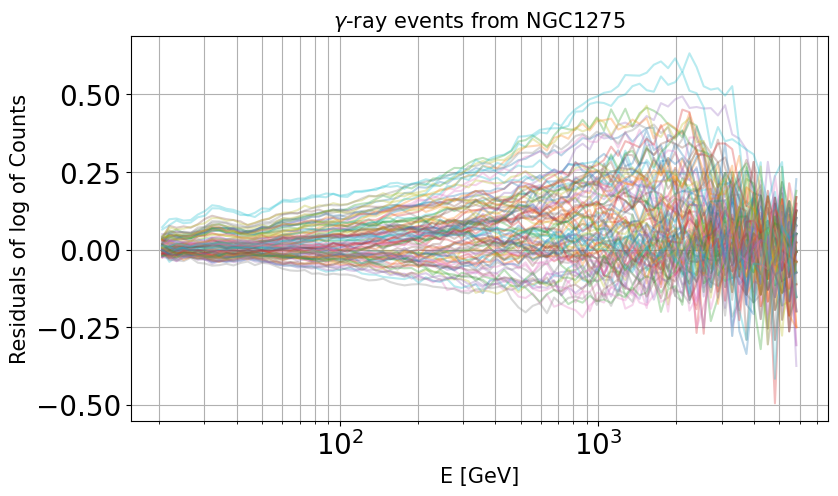

In [5]:
A.configure_plot(xmin=None, xmax=None, ymin=None,ymax=None,legend=0, logx=1, logy=0)
for i in range(min(len(samples),100)):
    A.configure_model(params=samples[i]['params'])
    A.import_counts(obs=samples[i]['data'],exp=samples[i]['exp'])
    new_fig = 1 if i==0 else 0
    A.compute_case(new_fig=new_fig,new_counts=0,color=None,color_obs=None,linestyle="-",
                   label_exp=0,label_obs=False, errorbands=False, errors=False, plot_exp=0, transparency=0.7)

In [6]:
def obs_comparison(obs_vec, sample_vec,widths):
  
    return np.sum(((obs_vec-sample_vec)/widths)**2,axis=-1)

def find_obs_matches(target_obs, n=None, bounds=bounds, samples=samples, component_to_compare="exp",component_indices=[],log=False):
    if not n: n = 5
    if len(component_indices)==0: component_indices = np.arange(samples[component_to_compare].shape[1])

    if not log:
        widths = np.max(samples[component_to_compare][:,component_indices],axis=0)-np.min(samples[component_to_compare][:,component_indices],axis=0)
        matches = np.argsort(obs_comparison(np.array([target_obs[component_to_compare]])[:,component_indices], samples[component_to_compare][:,component_indices], widths))[:n]
    else:
        widths = np.max(np.log(samples[component_to_compare][:,component_indices]),axis=0)-np.min(np.log(samples[component_to_compare][:,component_indices]),axis=0)
        matches = np.argsort(obs_comparison(np.log(np.array([target_obs[component_to_compare]])[:,component_indices]), np.log(samples[component_to_compare][:,component_indices]), widths))[:n]
    
    return matches.astype(int)

def plot_obs_matches(target_obs, n=None, color='r', bounds=bounds, samples=samples, component_to_compare="data",component_indices=[],
                    plot_hist = False):
    if not n: n = 5
    matches = list(np.zeros(n))
    matches = find_obs_matches(target_obs, n=n, bounds=bounds, samples=samples,component_to_compare=component_to_compare, component_indices=component_indices)
    if plot_hist:
        fig_hist = plt.figure(figsize=(12,12))
        for i in range(len(bounds)):
            fig_hist.add_subplot(6,3,i+1)
            # plt.subplot(1,len(bounds),i+1)
            plt.hist(samples['params'][matches,i], range=bounds[i],bins=50)
            plt.title(A.param_names[i])
            plt.axvline(target_obs['params'][i], color='r')
    A.configure_plot(xmin = None, xmax = None, ymin=None, ymax=None, logx=1, legend = 1)
    A.compute_case(new_fig=1,null=1,plot_obs=0,color="k",linestyle="--", label_exp=1)
    for j, match in enumerate(matches):
        A.configure_model(params=samples["params"][match])
        A.import_counts(exp=samples["exp"][match],obs=samples["data"][match])
        A.compute_case(new_fig=0,new_counts=0,plot_obs=0,color=color,label_exp=0, errorbands=False, transparency=0.5)    
    
    return matches

In [7]:
class References():

    def __init__(
        self,
        samples_for_fit = None,
        x_freq = None,
        y_freq = None,
        x_exponent = None,
        y_exponent = None,
        x_phase = None,
        y_phase = None,
        min_freq = 1,
        max_freq = 1.4,
        min_freq_gap = 0.15,
        min_exponent = 0.8,
        max_exponent = 1.5,
        min_exponent_gap = 0.3,
        device = 'cpu',
    ):
        
        self.x_freq = x_freq
        self.y_freq = y_freq
        self.x_exponent = x_exponent
        self.y_exponent = y_exponent
        self.x_phase = x_phase
        self.y_phase = y_phase
        self.min_freq = min_freq
        self.max_freq = max_freq
        self.min_freq_gap = min_freq_gap
        self.min_exponent = min_exponent
        self.max_exponent = max_exponent
        self.min_exponent_gap = min_exponent_gap

        self.fitted_parameters1 = None
        self.fitted_parameters2 = None
        self.phase_function1 = None
        self.phase_function2 = None
        if not samples_for_fit is None: self.fit_samples(samples_for_fit)


    def weight(self,exp,n_bins):
        x = np.linspace(-1,1,n_bins)
        return 0.5+0.5*np.cos(np.pi*np.sign(x)*np.abs(x)**exp)
    
    def standardized_sums(
        self,
        parsed_samples,
    ):
        try:
            samples = parsed_samples['data']
        except IndexError:
            samples = parsed_samples
     
        data_length = len(samples[0]) 
        start_of_range1 = np.random.randint(0,data_length)
        end_of_range1 = (start_of_range1 + int(data_length/2)) #np.random.randint( start_of_range1+int(data_length/3) , start_of_range1+int(2*data_length/3) )
        exp1 = np.random.uniform(0.5,2)
        exp2 = np.random.uniform(0.5,2)
        range1 = np.arange(start_of_range1,end_of_range1)%data_length
        range2 = np.arange(end_of_range1,end_of_range1+(start_of_range1-end_of_range1)%data_length)%data_length
    
        reordered_range1 = (np.concatenate([range1,range2])-int(data_length/2))%data_length
        reordered_range2 = (np.concatenate([range2,range1])-int(data_length/2))%data_length
        
        weights1 = self.weight(exp1,data_length)[reordered_range1]
        weights2 = self.weight(exp2,data_length)[reordered_range2]
    
        #>#
        samples1 = samples.copy()
        samples2 = samples.copy()
        #<#
    
        #>#
        bin_mins1 = np.min(samples1, axis=0)
        bin_maxes1 = np.max(samples1, axis=0)
        #<#
    
        #>#
        sums_of_standardized_bins1 = np.sum( weights1*((samples1-bin_mins1)/(bin_maxes1-bin_mins1)) ,axis=1)
        sums_of_standardized_bins1 = np.where(np.isinf(sums_of_standardized_bins1),0,sums_of_standardized_bins1)
        #<#
    
        max_sum1 = np.max(sums_of_standardized_bins1)
        min_sum1 = np.min(sums_of_standardized_bins1)
        standardized_sums1 = (sums_of_standardized_bins1-min_sum1)/(max_sum1-min_sum1)
    
        #>#
        bin_mins2 = np.min(samples2, axis=0)
        bin_maxes2 = np.max(samples2, axis=0)
        #<#
        
        #>#
        sums_of_standardized_bins2 = np.sum( weights2*((samples2-bin_mins2)/(bin_maxes2-bin_mins2)) ,axis=1)
        #<#
        
        sums_of_standardized_bins2 = np.where(np.isinf(sums_of_standardized_bins2),0,sums_of_standardized_bins2)
    
        max_sum2 = np.max(sums_of_standardized_bins2)
        min_sum2 = np.min(sums_of_standardized_bins2)
        standardized_sums2 = (sums_of_standardized_bins2-min_sum2)/(max_sum2-min_sum2)

        random_variables = {
            'range1':range1,
            'range2':range2,
        }

        return standardized_sums1, standardized_sums2, random_variables

    
    def fit_samples(
        self,
        standardized_sums1,
        standardized_sums2,
    ):
        print('Fitting samples...', flush=True, end='')
        fitted_parameters1 = lognorm.fit(standardized_sums1)
        fitted_parameters2 = lognorm.fit(standardized_sums2)
        print(' done.')
        
        phase_function1 = lognorm(fitted_parameters1[0], fitted_parameters1[1], fitted_parameters1[2]).cdf
        phase_function2 = lognorm(fitted_parameters2[0], fitted_parameters2[1], fitted_parameters2[2]).cdf
        
        self.fitted_parameters1 = fitted_parameters1
        self.fitted_parameters2 = fitted_parameters2

        self.phase_function1 = phase_function1
        self.phase_function2 = phase_function2
        

    def references2D(
        self,
        parsed_samples,
    ):
    
        standardized_sums1,standardized_sums2,rvs = self.standardized_sums(parsed_samples)
    
        #>#
        sorted_sums1 = np.sort(standardized_sums1)
        sorted_sums2 = np.sort(standardized_sums2)
        #<#
    
        #>#
        try:
            phase_for_check1 = self.phase_function1(sorted_sums1)
            phase_for_check2 = self.phase_function2(sorted_sums2)
            phase1 = self.phase_function1(standardized_sums1)
            phase2 = self.phase_function2(standardized_sums2)
        except Exception as Err:
            if self.phase_function1 is None or self.phase_function2 is None:
                self.fit_samples(standardized_sums1,standardized_sums1)
                phase_for_check1 = self.phase_function1(sorted_sums1)
                phase_for_check2 = self.phase_function2(sorted_sums2)
                phase1 = self.phase_function1(standardized_sums1)
                phase2 = self.phase_function2(standardized_sums2)
            else:
                raise Err 
        #<#

        x_freq = copy.copy(self.x_freq)
        y_freq = copy.copy(self.y_freq)
        x_exponent = copy.copy(self.x_exponent)
        y_exponent = copy.copy(self.y_exponent)
        x_phase = copy.copy(self.x_phase)
        y_phase = copy.copy(self.y_phase)
        min_freq = copy.copy(self.min_freq)
        max_freq = copy.copy(self.max_freq)
        min_freq_gap = copy.copy(self.min_freq_gap)
        min_exponent = copy.copy(self.min_exponent)
        max_exponent = copy.copy(self.max_exponent)
        min_exponent_gap = copy.copy(self.min_exponent_gap)

        #>#
        if x_phase is None: x_phase = np.random.uniform(0,1)
        if y_phase is None: y_phase = np.random.uniform(0,1)
    
        freq_range = max_freq-min_freq
        if x_freq is None: x_freq = np.random.uniform(min_freq,max_freq)
        if y_freq is None: y_freq = np.random.uniform(min(x_freq+min_freq_gap,max_freq)-min_freq, freq_range+max(x_freq-min_freq-min_freq_gap,0))%(freq_range) + min_freq
        
        if x_exponent is None: x_exponent = np.random.uniform(min_exponent,1) if x_freq > y_freq else np.random.uniform(1,max_exponent)
        if y_exponent is None: y_exponent = np.random.uniform(min_exponent,min(1,x_exponent-min_exponent_gap)) if x_freq < y_freq else np.random.uniform(max(1,x_exponent+min_exponent_gap),max_exponent)
    
        x_values_for_check = 0.5 + 0.5*np.sin(2*np.pi*(( x_freq*phase_for_check1)**x_exponent + x_phase ))
        y_values_for_check = 0.5 + 0.5*np.sin(2*np.pi*(( y_freq*phase_for_check2)**y_exponent + y_phase ))
        
        x_values = 0.5 + 0.5*np.sin(2*np.pi*(( x_freq*phase1)**x_exponent + x_phase ))
        y_values = 0.5 + 0.5*np.sin(2*np.pi*(( y_freq*phase2)**y_exponent + y_phase ))
        #<#
    
        random_variables = {
            'range1':rvs['range1'],
            'range2':rvs['range2'],
            'x_freq':x_freq,
            'y_freq':y_freq,
            'x_exponent':x_exponent,
            'y_exponent':y_exponent,
            'x_phase':x_phase,
            'y_phase':y_phase,
            'sums1':standardized_sums1,
            'sums2':standardized_sums2,
            'sorted_sums1':sorted_sums1,
            'sorted_sums2':sorted_sums2,
            'fitted_parameters1': self.fitted_parameters1,
            'fitted_parameters2': self.fitted_parameters2,
        }
        
        return np.array([x_values,y_values]).transpose(), np.array([x_values_for_check,y_values_for_check]).transpose(), random_variables
    

In [8]:
R = References()

Fitting samples... done.
CPU times: user 1.03 s, sys: 311 ms, total: 1.34 s
Wall time: 1.01 s


Text(0.5, 0, 'Normalized sum')

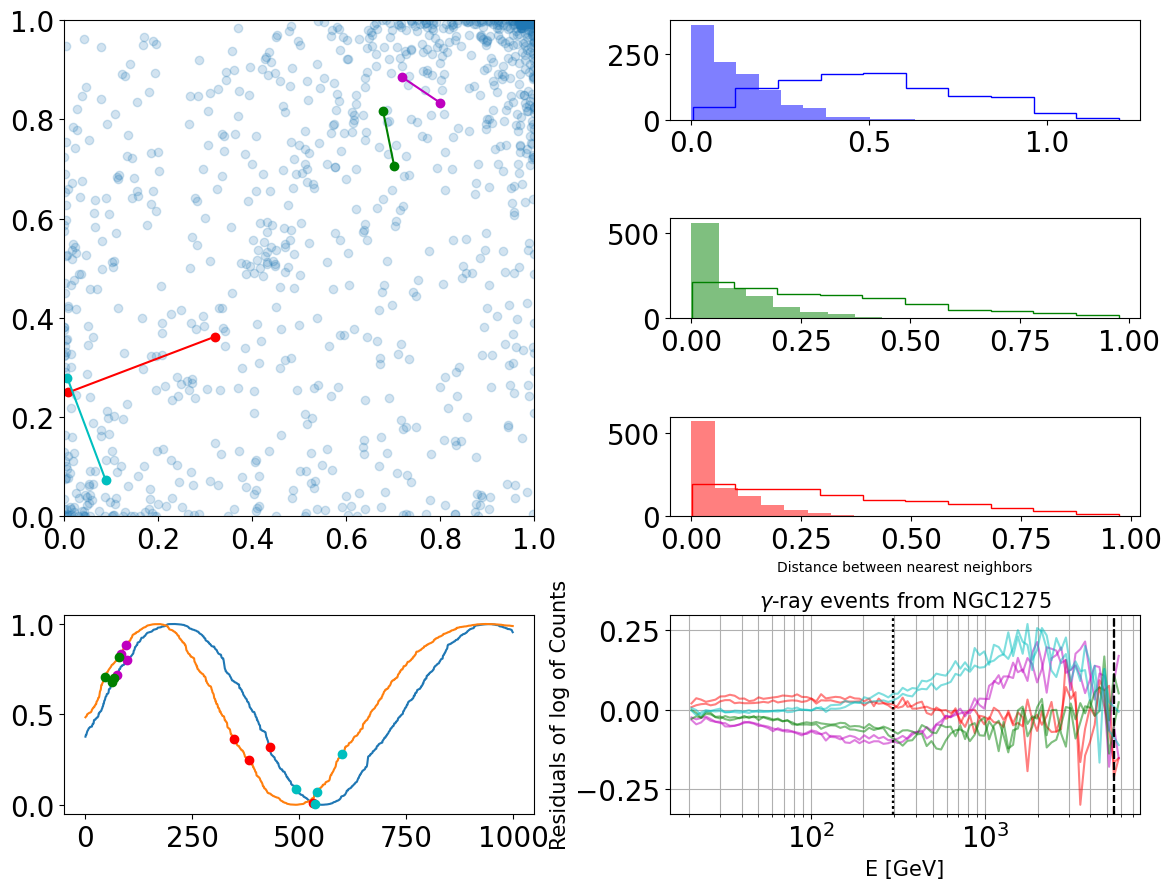

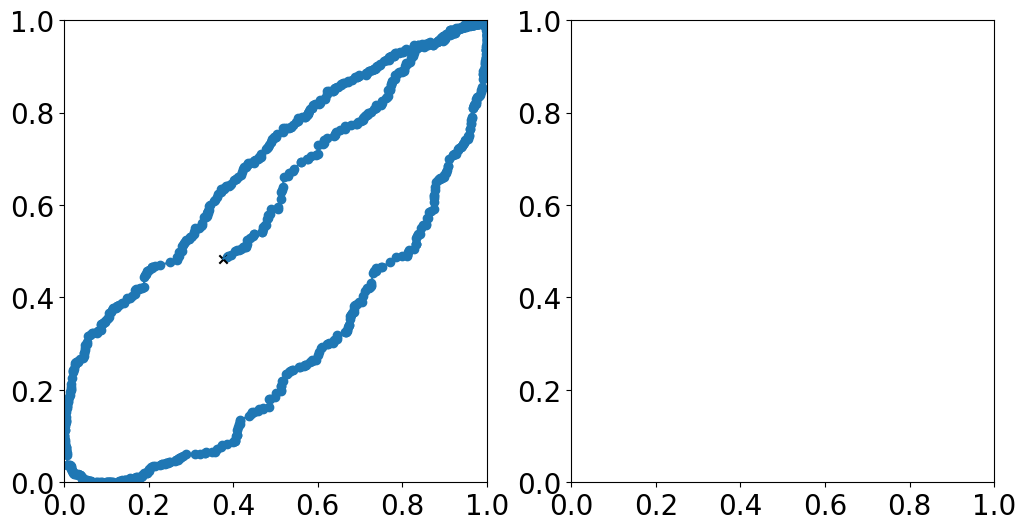

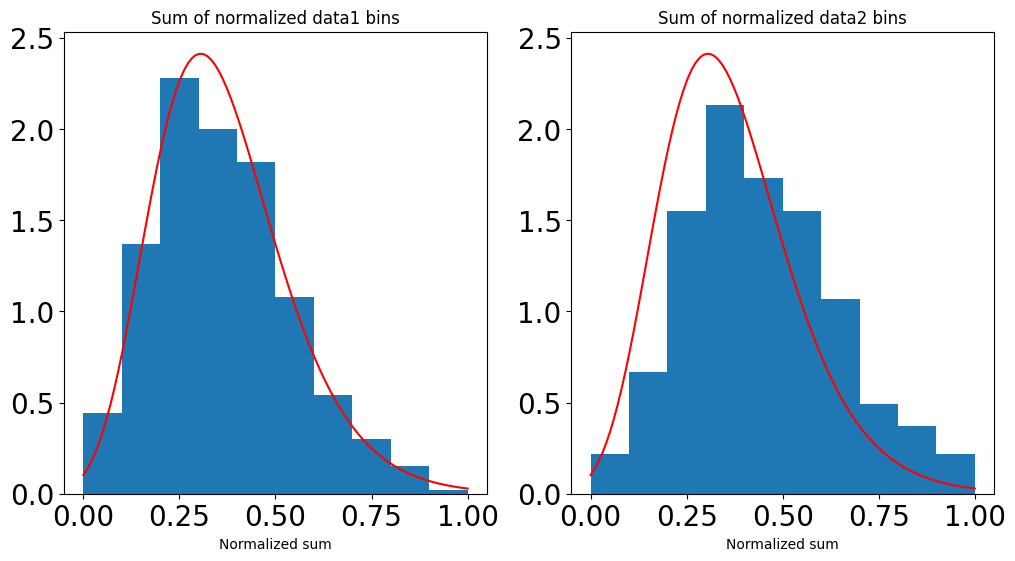

In [9]:
%%time

n_sim_coverage = 1_000

references, references_for_check, random_variables = R.references2D(samples[-n_sim_coverage:])

x_values = references[:,0]
y_values = references[:,1]

x_values_for_check = references_for_check[:,0]
y_values_for_check = references_for_check[:,1]

range1 = random_variables['range1']
range2 = random_variables['range2']
selected_data1 = random_variables['sums1']
selected_data2 = random_variables['sums2']
sorted_data1 = random_variables['sorted_sums1']
sorted_data2 = random_variables['sorted_sums2']
fitted_parameters1 = random_variables['fitted_parameters1']
fitted_parameters2 = random_variables['fitted_parameters2']

nearest_neighbors = np.zeros(n_sim_coverage,dtype=int)
distances = np.zeros(n_sim_coverage)
for i in range(n_sim_coverage):  
    nearest_neighbors[i] = find_obs_matches(samples[-n_sim_coverage:][i], 2, bounds=copy.deepcopy(bounds), samples=samples[-n_sim_coverage:],
                               component_to_compare='data', component_indices=[], log=False)[-1]
distances = np.sqrt( (x_values[nearest_neighbors]-x_values)**2+(y_values[nearest_neighbors]-y_values)**2 )
x_distances = np.abs(x_values[nearest_neighbors]-x_values)
y_distances = np.abs(y_values[nearest_neighbors]-y_values)
random_x_values_1 = np.random.uniform(size=n_sim_coverage)
random_y_values_1 = np.random.uniform(size=n_sim_coverage)
random_x_values_2 = np.random.uniform(size=n_sim_coverage)
random_y_values_2 = np.random.uniform(size=n_sim_coverage)
random_distances = np.sqrt((random_x_values_1-random_x_values_2)**2+(random_y_values_1-random_y_values_2)**2)
random_x_distances = np.abs(random_x_values_1-random_x_values_2)
random_y_distances = np.abs(random_y_values_1-random_y_values_2)

gs = gridspec.GridSpec(9,6)
spread_figure = plt.figure(figsize=(12,9))
spread_figure.add_subplot(gs[:6,:3])
spread_figure.add_subplot(gs[:2,3:])
spread_figure.add_subplot(gs[2:4,3:])
spread_figure.add_subplot(gs[4:6,3:])
spread_figure.add_subplot(gs[6:,:3])
spread_figure.add_subplot(gs[6:,3:])
# spread_figure.subplots_adjust(wspace=0.4,hspace=0.4)
spread_figure.axes[0].set_xlim([0,1])
spread_figure.axes[0].set_ylim([0,1])
spread_figure.axes[0].scatter(x_values,y_values,alpha=0.2)
# for i in range(n_sim_coverage):
#     spread_figure.axes[0].plot([x_values[i],x_values[nearest_neighbors[i]]],[y_values[i],y_values[nearest_neighbors[i]]], 'b:',alpha=0.2)
spread_figure.axes[1].hist(random_distances,color='b',histtype='step')
spread_figure.axes[1].hist(distances,alpha=0.5,color='b')
spread_figure.axes[2].hist(random_x_distances,color='g',histtype='step')
spread_figure.axes[2].hist(x_distances,alpha=0.5,color='g')
spread_figure.axes[3].hist(random_y_distances,color='r',histtype='step')
spread_figure.axes[3].hist(y_distances,alpha=0.5,color='r')
spread_figure.axes[3].set_xlabel('Distance between nearest neighbors')
n_random_indices = 4
random_indices = np.random.randint(0,n_sim_coverage,size=n_random_indices)
random_index_colors = ['r','m','g','c']
# fft_len = len(samples["data2"][0])
# fft_x_values = np.linspace(0,3,fft_len)
plot_obs = 1
A.configure_plot(legend=False)
for j,i in enumerate(random_indices):
    A.import_counts(exp=samples[-n_sim_coverage:]["exp"][i],obs=samples["data"][-n_sim_coverage:][i])
    A.compute_case(new_fig=0,new_counts=0,plot_obs=plot_obs,plot_exp=not plot_obs,color=random_index_colors[j],label_exp=0, errorbands=False, 
                   transparency=0.5,axes=spread_figure.axes[5],color_obs=random_index_colors[j],errors=False,label_obs=False) 
    A.import_counts(exp=samples[-n_sim_coverage:]["exp"][nearest_neighbors[i]],obs=samples["data"][-n_sim_coverage:][nearest_neighbors[i]])
    A.compute_case(new_fig=0,new_counts=0,plot_obs=plot_obs,plot_exp=not plot_obs,color=random_index_colors[j],label_exp=0, errorbands=False,
                   transparency=0.5,axes=spread_figure.axes[5],color_obs=random_index_colors[j],errors=False,label_obs=False) 
    spread_figure.axes[5].axvline(A.bin_centers[range1[0]], linestyle='--', color='k')
    spread_figure.axes[5].axvline(A.bin_centers[range1[-1]], linestyle=':', color='k')
    spread_figure.axes[0].plot([x_values[i],x_values[nearest_neighbors[i]]],[y_values[i],y_values[nearest_neighbors[i]]],
                               color=random_index_colors[j],linestyle='-',zorder=2)
    spread_figure.axes[0].scatter([x_values[i],x_values[nearest_neighbors[i]]],[y_values[i],y_values[nearest_neighbors[i]]],
                               color=random_index_colors[j],zorder=2)
# spread_figure.axes[3].set_yscale("log")
# spread_figure.axes[5].set_ylabel('$\log |F_k|^2$',size=A.fontsize)
# spread_figure.axes[5].set_xlabel('Frequency [$\log(E/\mathrm{GeV})^{-1}$]',size=A.fontsize)
spread_figure.tight_layout(w_pad=0.8)

check_figure = plt.figure(figsize=(12,6))
check_figure.add_subplot(1,2,1)
check_figure.axes[0].scatter(x_values_for_check[1:],y_values_for_check[1:])
check_figure.axes[0].scatter(x_values_for_check[0],y_values_for_check[0],marker='x',color='k')
check_figure.axes[0].plot(x_values_for_check,y_values_for_check)

# check_figure.axes[0].scatter(not_rotated_x_values_for_check[1:],not_rotated_y_values_for_check[1:],color='r')
# check_figure.axes[0].scatter(not_rotated_x_values_for_check[0],not_rotated_y_values_for_check[0],marker='x',color='k')
# check_figure.axes[0].plot(not_rotated_x_values_for_check,not_rotated_y_values_for_check,color='r')

check_figure.axes[0].set_xlim([0,1])
check_figure.axes[0].set_ylim([0,1])
check_figure.add_subplot(1,2,2)
spread_figure.axes[4].plot(x_values_for_check)
spread_figure.axes[4].plot(y_values_for_check)
for j,i in enumerate(random_indices):
    index_in_sorted_data1 = np.where(sorted_data1==selected_data1[i])[0]
    index_in_sorted_data2 = np.where(sorted_data2==selected_data2[i])[0]
    spread_figure.axes[4].scatter([index_in_sorted_data1],[x_values_for_check[index_in_sorted_data1]],color=random_index_colors[j],zorder=2)
    spread_figure.axes[4].scatter([index_in_sorted_data2],[y_values_for_check[index_in_sorted_data2]],color=random_index_colors[j],zorder=2)
    index_in_sorted_data1 = np.where(sorted_data1==selected_data1[nearest_neighbors[i]])[0]
    index_in_sorted_data2 = np.where(sorted_data2==selected_data2[nearest_neighbors[i]])[0]
    spread_figure.axes[4].scatter([index_in_sorted_data1],[x_values_for_check[index_in_sorted_data1]],color=random_index_colors[j],zorder=2)
    spread_figure.axes[4].scatter([index_in_sorted_data2],[y_values_for_check[index_in_sorted_data2]],color=random_index_colors[j],zorder=2)
    
    
x = np.linspace(0,1,100)
fits_figure = plt.figure(figsize=(12,6))
fits_figure.add_subplot(1,2,1)
fits_figure.axes[0].plot(x, lognorm(fitted_parameters1[0], fitted_parameters1[1], fitted_parameters1[2]).pdf(x), color = 'r')
fits_figure.axes[0].hist(sorted_data1, density=True)
fits_figure.axes[0].set_title('Sum of normalized data1 bins')
fits_figure.axes[0].set_xlabel('Normalized sum')
fits_figure.add_subplot(1,2,2)
fits_figure.axes[1].plot(x, lognorm(fitted_parameters2[0], fitted_parameters2[1], fitted_parameters2[2]).pdf(x), color = 'r')
fits_figure.axes[1].hist(sorted_data2, density=True)
fits_figure.axes[1].set_title('Sum of normalized data2 bins')
fits_figure.axes[1].set_xlabel('Normalized sum')



NameError: name 'random' is not defined

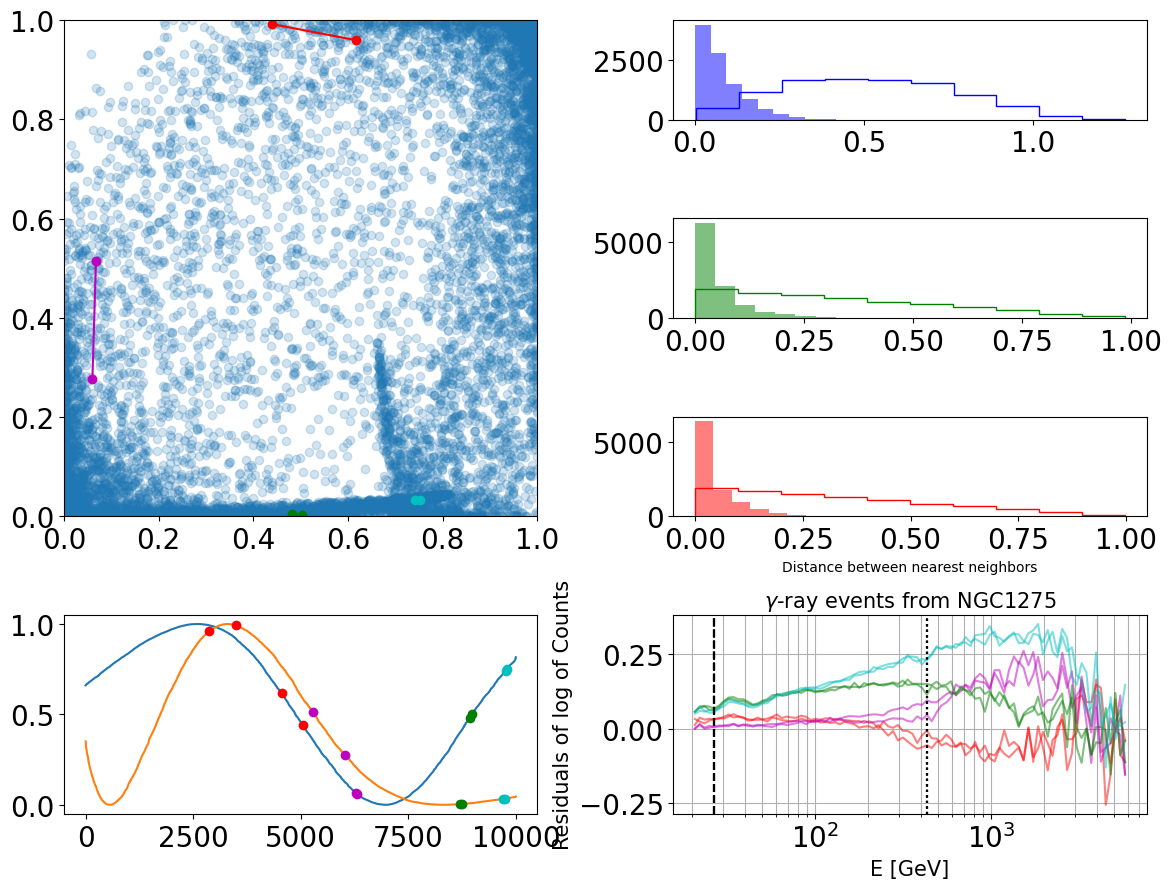

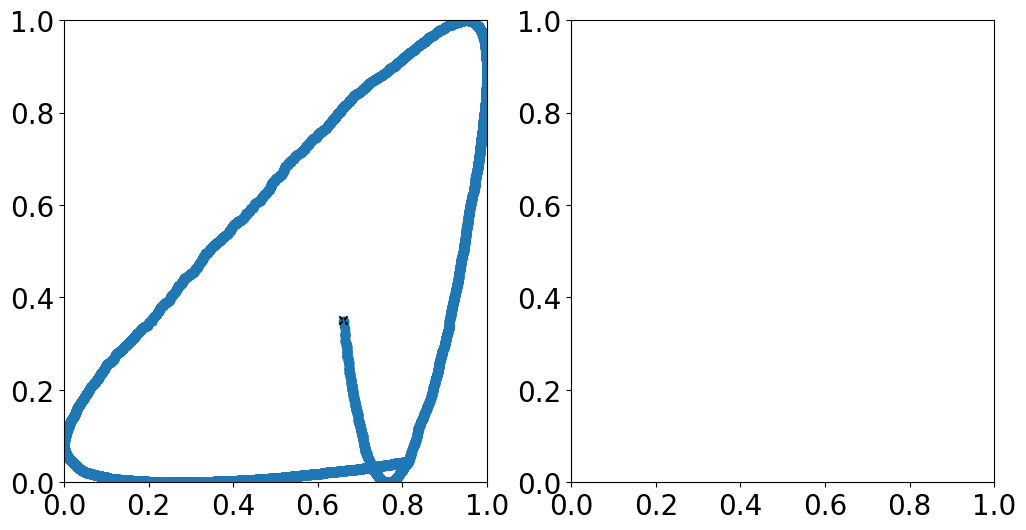

In [10]:
%%time

n_sim_coverage = 10_000

references, references_for_check, random_variables = R.references2D(samples[-n_sim_coverage:])

x_values = references[:,0]
y_values = references[:,1]

x_values_for_check = references_for_check[:,0]
y_values_for_check = references_for_check[:,1]

range1 = random_variables['range1']
range2 = random_variables['range2']
selected_data1 = random_variables['sums1']
selected_data2 = random_variables['sums2']
sorted_data1 = random_variables['sorted_sums1']
sorted_data2 = random_variables['sorted_sums2']
fitted_parameters1 = random_variables['fitted_parameters1']
fitted_parameters2 = random_variables['fitted_parameters2']

nearest_neighbors = np.zeros(n_sim_coverage,dtype=int)
distances = np.zeros(n_sim_coverage)
for i in range(n_sim_coverage):  
    nearest_neighbors[i] = find_obs_matches(samples[-n_sim_coverage:][i], 2, bounds=copy.deepcopy(bounds), samples=samples[-n_sim_coverage:],
                               component_to_compare='data', component_indices=[], log=False)[-1]
distances = np.sqrt( (x_values[nearest_neighbors]-x_values)**2+(y_values[nearest_neighbors]-y_values)**2 )
x_distances = np.abs(x_values[nearest_neighbors]-x_values)
y_distances = np.abs(y_values[nearest_neighbors]-y_values)
random_x_values_1 = np.random.uniform(size=n_sim_coverage)
random_y_values_1 = np.random.uniform(size=n_sim_coverage)
random_x_values_2 = np.random.uniform(size=n_sim_coverage)
random_y_values_2 = np.random.uniform(size=n_sim_coverage)
random_distances = np.sqrt((random_x_values_1-random_x_values_2)**2+(random_y_values_1-random_y_values_2)**2)
random_x_distances = np.abs(random_x_values_1-random_x_values_2)
random_y_distances = np.abs(random_y_values_1-random_y_values_2)

gs = gridspec.GridSpec(9,6)
spread_figure = plt.figure(figsize=(12,9))
spread_figure.add_subplot(gs[:6,:3])
spread_figure.add_subplot(gs[:2,3:])
spread_figure.add_subplot(gs[2:4,3:])
spread_figure.add_subplot(gs[4:6,3:])
spread_figure.add_subplot(gs[6:,:3])
spread_figure.add_subplot(gs[6:,3:])
# spread_figure.subplots_adjust(wspace=0.4,hspace=0.4)
spread_figure.axes[0].set_xlim([0,1])
spread_figure.axes[0].set_ylim([0,1])
spread_figure.axes[0].scatter(x_values,y_values,alpha=0.2)
# for i in range(n_sim_coverage):
#     spread_figure.axes[0].plot([x_values[i],x_values[nearest_neighbors[i]]],[y_values[i],y_values[nearest_neighbors[i]]], 'b:',alpha=0.2)
spread_figure.axes[1].hist(random_distances,color='b',histtype='step')
spread_figure.axes[1].hist(distances,alpha=0.5,color='b')
spread_figure.axes[2].hist(random_x_distances,color='g',histtype='step')
spread_figure.axes[2].hist(x_distances,alpha=0.5,color='g')
spread_figure.axes[3].hist(random_y_distances,color='r',histtype='step')
spread_figure.axes[3].hist(y_distances,alpha=0.5,color='r')
spread_figure.axes[3].set_xlabel('Distance between nearest neighbors')
n_random_indices = 4
random_indices = np.random.randint(0,n_sim_coverage,size=n_random_indices)
random_index_colors = ['r','m','g','c']
# fft_len = len(samples["data2"][0])
# fft_x_values = np.linspace(0,3,fft_len)
plot_obs = 1
A.configure_plot(legend=False)
for j,i in enumerate(random_indices):
    A.import_counts(exp=samples[-n_sim_coverage:]["exp"][i],obs=samples["data"][-n_sim_coverage:][i])
    A.compute_case(new_fig=0,new_counts=0,plot_obs=plot_obs,plot_exp=not plot_obs,color=random_index_colors[j],label_exp=0, errorbands=False, 
                   transparency=0.5,axes=spread_figure.axes[5],color_obs=random_index_colors[j],errors=False,label_obs=False) 
    A.import_counts(exp=samples[-n_sim_coverage:]["exp"][nearest_neighbors[i]],obs=samples["data"][-n_sim_coverage:][nearest_neighbors[i]])
    A.compute_case(new_fig=0,new_counts=0,plot_obs=plot_obs,plot_exp=not plot_obs,color=random_index_colors[j],label_exp=0, errorbands=False,
                   transparency=0.5,axes=spread_figure.axes[5],color_obs=random_index_colors[j],errors=False,label_obs=False) 
    spread_figure.axes[5].axvline(A.bin_centers[range1[0]], linestyle='--', color='k')
    spread_figure.axes[5].axvline(A.bin_centers[range1[-1]], linestyle=':', color='k')
    spread_figure.axes[0].plot([x_values[i],x_values[nearest_neighbors[i]]],[y_values[i],y_values[nearest_neighbors[i]]],
                               color=random_index_colors[j],linestyle='-',zorder=2)
    spread_figure.axes[0].scatter([x_values[i],x_values[nearest_neighbors[i]]],[y_values[i],y_values[nearest_neighbors[i]]],
                               color=random_index_colors[j],zorder=2)
# spread_figure.axes[3].set_yscale("log")
# spread_figure.axes[5].set_ylabel('$\log |F_k|^2$',size=A.fontsize)
# spread_figure.axes[5].set_xlabel('Frequency [$\log(E/\mathrm{GeV})^{-1}$]',size=A.fontsize)
spread_figure.tight_layout(w_pad=0.8)

check_figure = plt.figure(figsize=(12,6))
check_figure.add_subplot(1,2,1)
check_figure.axes[0].scatter(x_values_for_check[1:],y_values_for_check[1:])
check_figure.axes[0].scatter(x_values_for_check[0],y_values_for_check[0],marker='x',color='k')
check_figure.axes[0].plot(x_values_for_check,y_values_for_check)

# check_figure.axes[0].scatter(not_rotated_x_values_for_check[1:],not_rotated_y_values_for_check[1:],color='r')
# check_figure.axes[0].scatter(not_rotated_x_values_for_check[0],not_rotated_y_values_for_check[0],marker='x',color='k')
# check_figure.axes[0].plot(not_rotated_x_values_for_check,not_rotated_y_values_for_check,color='r')

check_figure.axes[0].set_xlim([0,1])
check_figure.axes[0].set_ylim([0,1])
check_figure.add_subplot(1,2,2)
spread_figure.axes[4].plot(x_values_for_check)
spread_figure.axes[4].plot(y_values_for_check)
for j,i in enumerate(random_indices):
    index_in_sorted_data1 = np.where(sorted_data1==selected_data1[i])[0]
    index_in_sorted_data2 = np.where(sorted_data2==selected_data2[i])[0]
    spread_figure.axes[4].scatter([index_in_sorted_data1],[x_values_for_check[index_in_sorted_data1]],color=random_index_colors[j],zorder=2)
    spread_figure.axes[4].scatter([index_in_sorted_data2],[y_values_for_check[index_in_sorted_data2]],color=random_index_colors[j],zorder=2)
    index_in_sorted_data1 = np.where(sorted_data1==selected_data1[nearest_neighbors[i]])[0]
    index_in_sorted_data2 = np.where(sorted_data2==selected_data2[nearest_neighbors[i]])[0]
    spread_figure.axes[4].scatter([index_in_sorted_data1],[x_values_for_check[index_in_sorted_data1]],color=random_index_colors[j],zorder=2)
    spread_figure.axes[4].scatter([index_in_sorted_data2],[y_values_for_check[index_in_sorted_data2]],color=random_index_colors[j],zorder=2)

fits_figure = plt.figure(figsize=(12,6))
fits_figure.add_subplot(1,2,1)
fits_figure.axes[0].plot(x, lognorm(fitted_parameters1[0], fitted_parameters1[1], fitted_parameters1[2]).pdf(x), color = 'r')
fits_figure.axes[0].hist(sorted_data1, density=True)
fits_figure.axes[0].set_title('Sum of normalized data1 bins')
fits_figure.axes[0].set_xlabel('Normalized sum')
fits_figure.add_subplot(1,2,2)
fits_figure.axes[1].plot(x, lognorm(fitted_parameters2[0], fitted_parameters2[1], fitted_parameters2[2]).pdf(x), color = 'r')
fits_figure.axes[1].hist(sorted_data2, density=True)
fits_figure.axes[1].set_title('Sum of normalized data2 bins')
fits_figure.axes[1].set_xlabel('Normalized sum')


CPU times: user 44.6 s, sys: 341 ms, total: 44.9 s
Wall time: 44.7 s


Text(0.5, 0, 'Normalized sum')

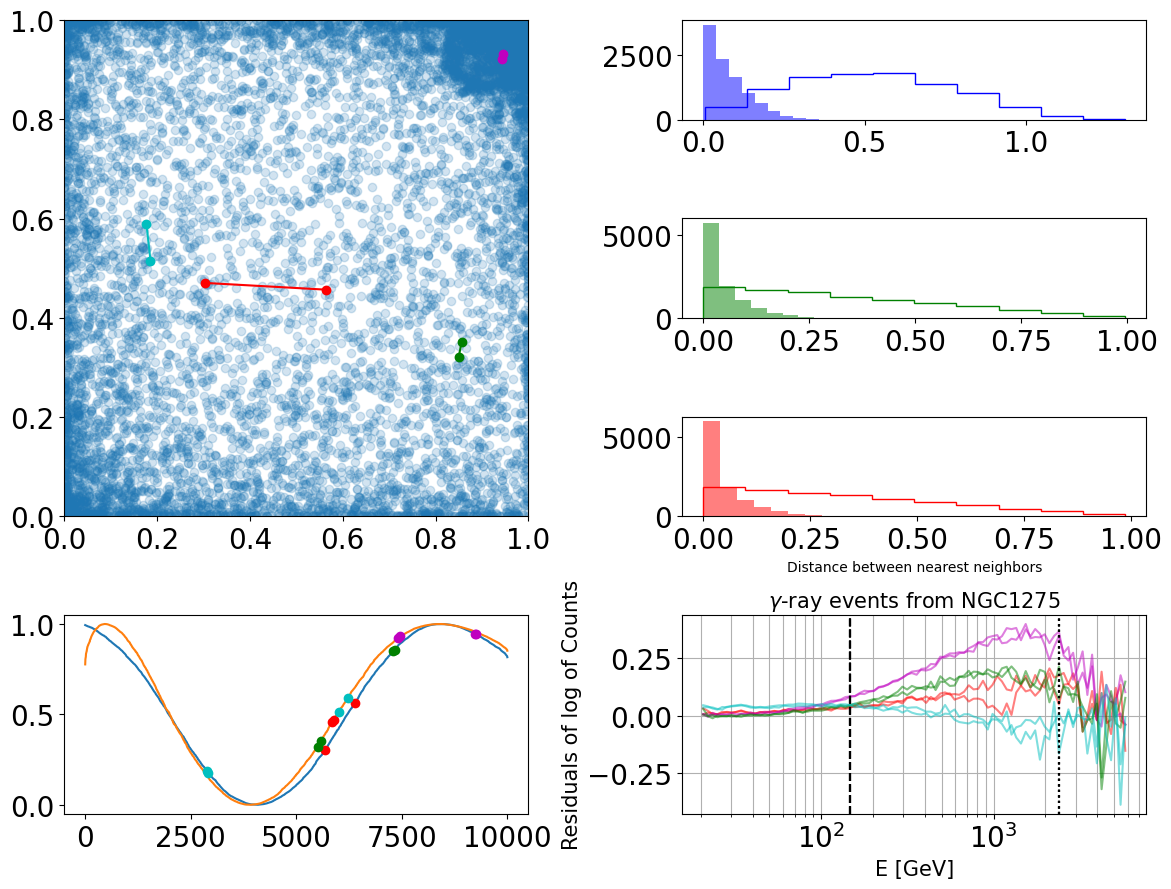

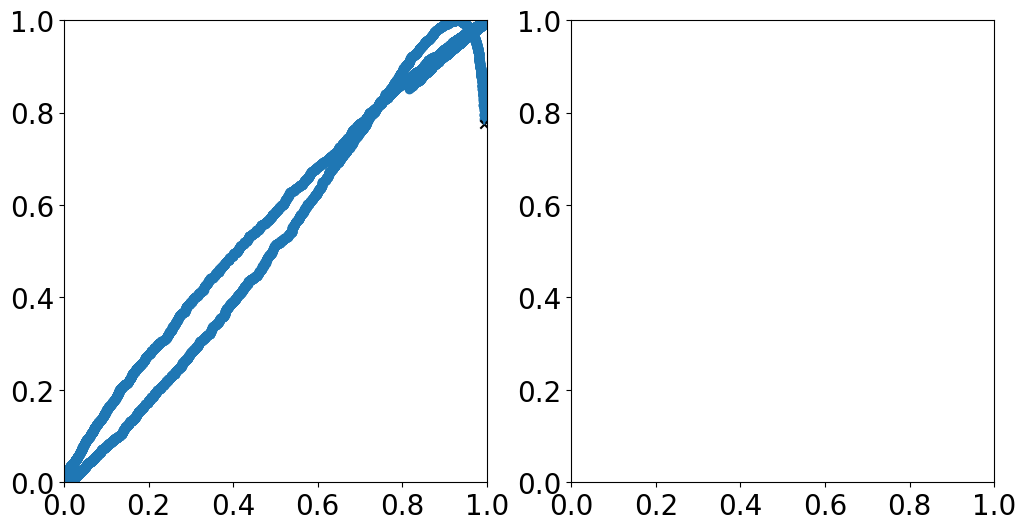

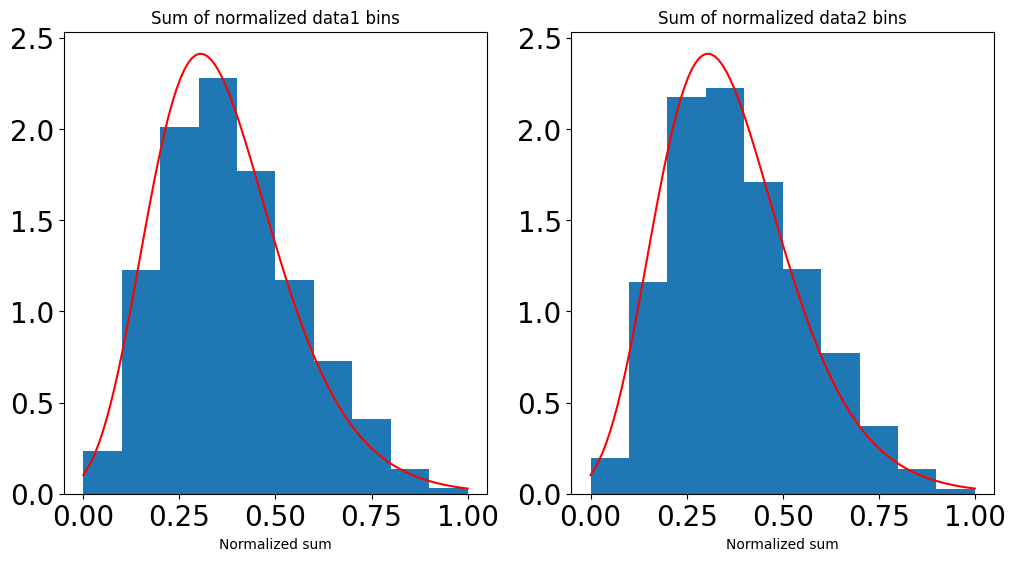

In [11]:
%%time

n_sim_coverage = 10_000

references, references_for_check, random_variables = R.references2D(samples[-n_sim_coverage:])

x_values = references[:,0]
y_values = references[:,1]

x_values_for_check = references_for_check[:,0]
y_values_for_check = references_for_check[:,1]

range1 = random_variables['range1']
range2 = random_variables['range2']
selected_data1 = random_variables['sums1']
selected_data2 = random_variables['sums2']
sorted_data1 = random_variables['sorted_sums1']
sorted_data2 = random_variables['sorted_sums2']
fitted_parameters1 = random_variables['fitted_parameters1']
fitted_parameters2 = random_variables['fitted_parameters2']

nearest_neighbors = np.zeros(n_sim_coverage,dtype=int)
distances = np.zeros(n_sim_coverage)
for i in range(n_sim_coverage):  
    nearest_neighbors[i] = find_obs_matches(samples[-n_sim_coverage:][i], 2, bounds=copy.deepcopy(bounds), samples=samples[-n_sim_coverage:],
                               component_to_compare='data', component_indices=[], log=False)[-1]
distances = np.sqrt( (x_values[nearest_neighbors]-x_values)**2+(y_values[nearest_neighbors]-y_values)**2 )
x_distances = np.abs(x_values[nearest_neighbors]-x_values)
y_distances = np.abs(y_values[nearest_neighbors]-y_values)
random_x_values_1 = np.random.uniform(size=n_sim_coverage)
random_y_values_1 = np.random.uniform(size=n_sim_coverage)
random_x_values_2 = np.random.uniform(size=n_sim_coverage)
random_y_values_2 = np.random.uniform(size=n_sim_coverage)
random_distances = np.sqrt((random_x_values_1-random_x_values_2)**2+(random_y_values_1-random_y_values_2)**2)
random_x_distances = np.abs(random_x_values_1-random_x_values_2)
random_y_distances = np.abs(random_y_values_1-random_y_values_2)

gs = gridspec.GridSpec(9,6)
spread_figure = plt.figure(figsize=(12,9))
spread_figure.add_subplot(gs[:6,:3])
spread_figure.add_subplot(gs[:2,3:])
spread_figure.add_subplot(gs[2:4,3:])
spread_figure.add_subplot(gs[4:6,3:])
spread_figure.add_subplot(gs[6:,:3])
spread_figure.add_subplot(gs[6:,3:])
# spread_figure.subplots_adjust(wspace=0.4,hspace=0.4)
spread_figure.axes[0].set_xlim([0,1])
spread_figure.axes[0].set_ylim([0,1])
spread_figure.axes[0].scatter(x_values,y_values,alpha=0.2)
# for i in range(n_sim_coverage):
#     spread_figure.axes[0].plot([x_values[i],x_values[nearest_neighbors[i]]],[y_values[i],y_values[nearest_neighbors[i]]], 'b:',alpha=0.2)
spread_figure.axes[1].hist(random_distances,color='b',histtype='step')
spread_figure.axes[1].hist(distances,alpha=0.5,color='b')
spread_figure.axes[2].hist(random_x_distances,color='g',histtype='step')
spread_figure.axes[2].hist(x_distances,alpha=0.5,color='g')
spread_figure.axes[3].hist(random_y_distances,color='r',histtype='step')
spread_figure.axes[3].hist(y_distances,alpha=0.5,color='r')
spread_figure.axes[3].set_xlabel('Distance between nearest neighbors')
n_random_indices = 4
random_indices = np.random.randint(0,n_sim_coverage,size=n_random_indices)
random_index_colors = ['r','m','g','c']
# fft_len = len(samples["data2"][0])
# fft_x_values = np.linspace(0,3,fft_len)
plot_obs = 1
A.configure_plot(legend=False)
for j,i in enumerate(random_indices):
    A.import_counts(exp=samples[-n_sim_coverage:]["exp"][i],obs=samples["data"][-n_sim_coverage:][i])
    A.compute_case(new_fig=0,new_counts=0,plot_obs=plot_obs,plot_exp=not plot_obs,color=random_index_colors[j],label_exp=0, errorbands=False, 
                   transparency=0.5,axes=spread_figure.axes[5],color_obs=random_index_colors[j],errors=False,label_obs=False) 
    A.import_counts(exp=samples[-n_sim_coverage:]["exp"][nearest_neighbors[i]],obs=samples["data"][-n_sim_coverage:][nearest_neighbors[i]])
    A.compute_case(new_fig=0,new_counts=0,plot_obs=plot_obs,plot_exp=not plot_obs,color=random_index_colors[j],label_exp=0, errorbands=False,
                   transparency=0.5,axes=spread_figure.axes[5],color_obs=random_index_colors[j],errors=False,label_obs=False) 
    spread_figure.axes[5].axvline(A.bin_centers[range1[0]], linestyle='--', color='k')
    spread_figure.axes[5].axvline(A.bin_centers[range1[-1]], linestyle=':', color='k')
    spread_figure.axes[0].plot([x_values[i],x_values[nearest_neighbors[i]]],[y_values[i],y_values[nearest_neighbors[i]]],
                               color=random_index_colors[j],linestyle='-',zorder=2)
    spread_figure.axes[0].scatter([x_values[i],x_values[nearest_neighbors[i]]],[y_values[i],y_values[nearest_neighbors[i]]],
                               color=random_index_colors[j],zorder=2)
# spread_figure.axes[3].set_yscale("log")
# spread_figure.axes[5].set_ylabel('$\log |F_k|^2$',size=A.fontsize)
# spread_figure.axes[5].set_xlabel('Frequency [$\log(E/\mathrm{GeV})^{-1}$]',size=A.fontsize)
spread_figure.tight_layout(w_pad=0.8)

check_figure = plt.figure(figsize=(12,6))
check_figure.add_subplot(1,2,1)
check_figure.axes[0].scatter(x_values_for_check[1:],y_values_for_check[1:])
check_figure.axes[0].scatter(x_values_for_check[0],y_values_for_check[0],marker='x',color='k')
check_figure.axes[0].plot(x_values_for_check,y_values_for_check)

# check_figure.axes[0].scatter(not_rotated_x_values_for_check[1:],not_rotated_y_values_for_check[1:],color='r')
# check_figure.axes[0].scatter(not_rotated_x_values_for_check[0],not_rotated_y_values_for_check[0],marker='x',color='k')
# check_figure.axes[0].plot(not_rotated_x_values_for_check,not_rotated_y_values_for_check,color='r')

check_figure.axes[0].set_xlim([0,1])
check_figure.axes[0].set_ylim([0,1])
check_figure.add_subplot(1,2,2)
spread_figure.axes[4].plot(x_values_for_check)
spread_figure.axes[4].plot(y_values_for_check)
for j,i in enumerate(random_indices):
    index_in_sorted_data1 = np.where(sorted_data1==selected_data1[i])[0]
    index_in_sorted_data2 = np.where(sorted_data2==selected_data2[i])[0]
    spread_figure.axes[4].scatter([index_in_sorted_data1],[x_values_for_check[index_in_sorted_data1]],color=random_index_colors[j],zorder=2)
    spread_figure.axes[4].scatter([index_in_sorted_data2],[y_values_for_check[index_in_sorted_data2]],color=random_index_colors[j],zorder=2)
    index_in_sorted_data1 = np.where(sorted_data1==selected_data1[nearest_neighbors[i]])[0]
    index_in_sorted_data2 = np.where(sorted_data2==selected_data2[nearest_neighbors[i]])[0]
    spread_figure.axes[4].scatter([index_in_sorted_data1],[x_values_for_check[index_in_sorted_data1]],color=random_index_colors[j],zorder=2)
    spread_figure.axes[4].scatter([index_in_sorted_data2],[y_values_for_check[index_in_sorted_data2]],color=random_index_colors[j],zorder=2)
    
    

fits_figure = plt.figure(figsize=(12,6))
fits_figure.add_subplot(1,2,1)
fits_figure.axes[0].plot(x, lognorm(fitted_parameters1[0], fitted_parameters1[1], fitted_parameters1[2]).pdf(x), color = 'r')
fits_figure.axes[0].hist(sorted_data1, density=True)
fits_figure.axes[0].set_title('Sum of normalized data1 bins')
fits_figure.axes[0].set_xlabel('Normalized sum')
fits_figure.add_subplot(1,2,2)
fits_figure.axes[1].plot(x, lognorm(fitted_parameters2[0], fitted_parameters2[1], fitted_parameters2[2]).pdf(x), color = 'r')
fits_figure.axes[1].hist(sorted_data2, density=True)
fits_figure.axes[1].set_title('Sum of normalized data2 bins')
fits_figure.axes[1].set_xlabel('Normalized sum')



CPU times: user 44.3 s, sys: 382 ms, total: 44.7 s
Wall time: 44.5 s


Text(0.5, 0, 'Normalized sum')

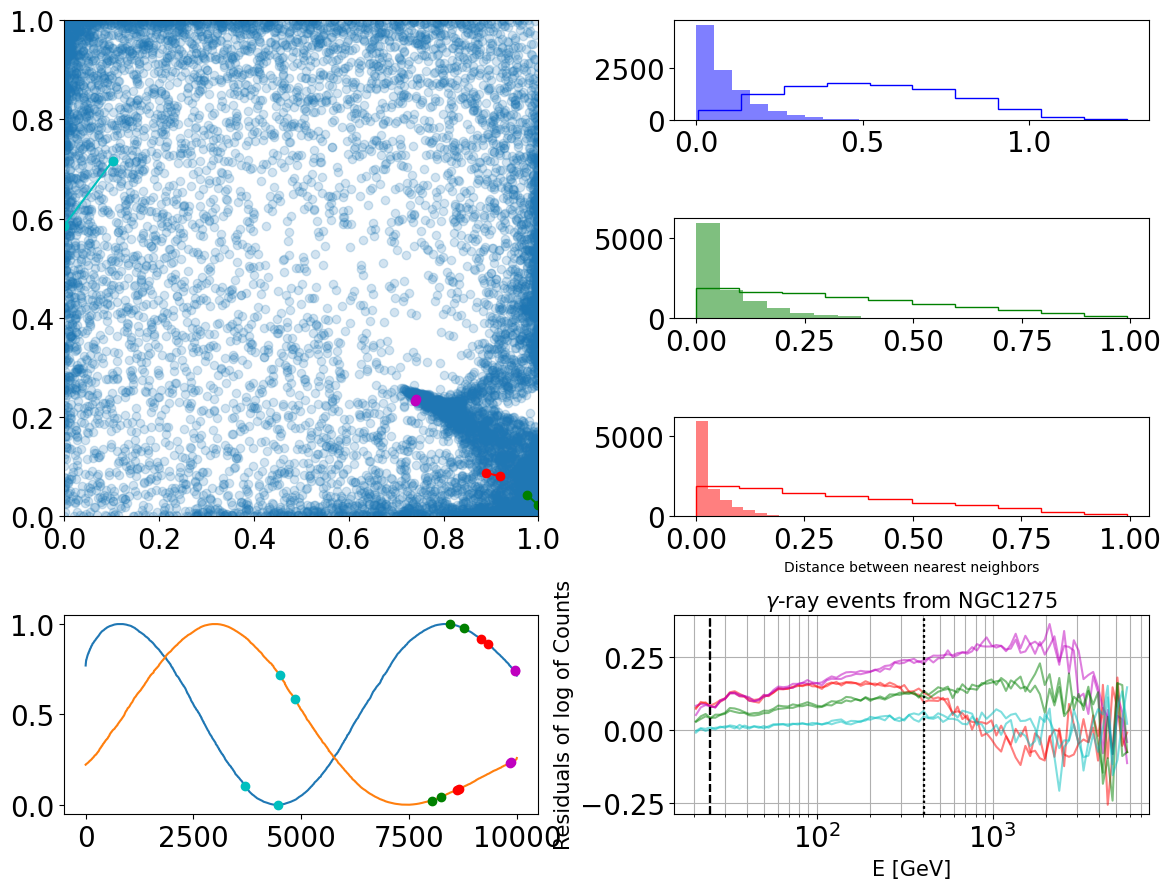

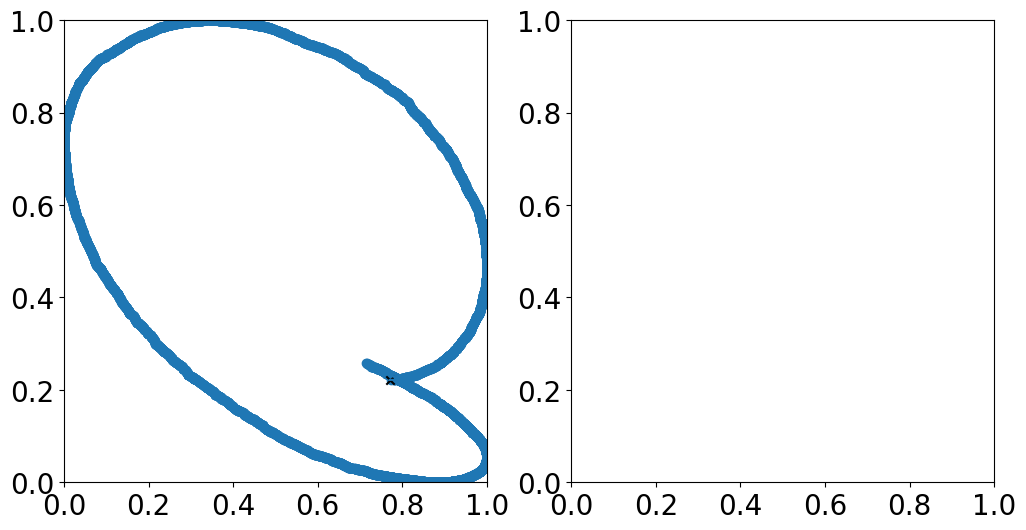

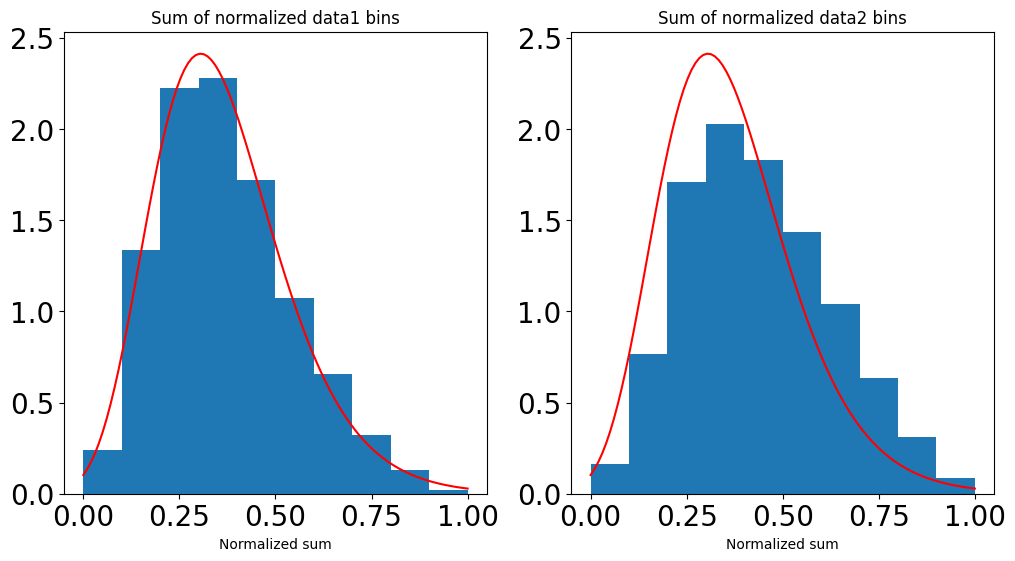

In [12]:
%%time

n_sim_coverage = 10_000

references, references_for_check, random_variables = R.references2D(samples[-n_sim_coverage:])

x_values = references[:,0]
y_values = references[:,1]

x_values_for_check = references_for_check[:,0]
y_values_for_check = references_for_check[:,1]

range1 = random_variables['range1']
range2 = random_variables['range2']
selected_data1 = random_variables['sums1']
selected_data2 = random_variables['sums2']
sorted_data1 = random_variables['sorted_sums1']
sorted_data2 = random_variables['sorted_sums2']
fitted_parameters1 = random_variables['fitted_parameters1']
fitted_parameters2 = random_variables['fitted_parameters2']

nearest_neighbors = np.zeros(n_sim_coverage,dtype=int)
distances = np.zeros(n_sim_coverage)
for i in range(n_sim_coverage):  
    nearest_neighbors[i] = find_obs_matches(samples[-n_sim_coverage:][i], 2, bounds=copy.deepcopy(bounds), samples=samples[-n_sim_coverage:],
                               component_to_compare='data', component_indices=[], log=False)[-1]
distances = np.sqrt( (x_values[nearest_neighbors]-x_values)**2+(y_values[nearest_neighbors]-y_values)**2 )
x_distances = np.abs(x_values[nearest_neighbors]-x_values)
y_distances = np.abs(y_values[nearest_neighbors]-y_values)
random_x_values_1 = np.random.uniform(size=n_sim_coverage)
random_y_values_1 = np.random.uniform(size=n_sim_coverage)
random_x_values_2 = np.random.uniform(size=n_sim_coverage)
random_y_values_2 = np.random.uniform(size=n_sim_coverage)
random_distances = np.sqrt((random_x_values_1-random_x_values_2)**2+(random_y_values_1-random_y_values_2)**2)
random_x_distances = np.abs(random_x_values_1-random_x_values_2)
random_y_distances = np.abs(random_y_values_1-random_y_values_2)

gs = gridspec.GridSpec(9,6)
spread_figure = plt.figure(figsize=(12,9))
spread_figure.add_subplot(gs[:6,:3])
spread_figure.add_subplot(gs[:2,3:])
spread_figure.add_subplot(gs[2:4,3:])
spread_figure.add_subplot(gs[4:6,3:])
spread_figure.add_subplot(gs[6:,:3])
spread_figure.add_subplot(gs[6:,3:])
# spread_figure.subplots_adjust(wspace=0.4,hspace=0.4)
spread_figure.axes[0].set_xlim([0,1])
spread_figure.axes[0].set_ylim([0,1])
spread_figure.axes[0].scatter(x_values,y_values,alpha=0.2)
# for i in range(n_sim_coverage):
#     spread_figure.axes[0].plot([x_values[i],x_values[nearest_neighbors[i]]],[y_values[i],y_values[nearest_neighbors[i]]], 'b:',alpha=0.2)
spread_figure.axes[1].hist(random_distances,color='b',histtype='step')
spread_figure.axes[1].hist(distances,alpha=0.5,color='b')
spread_figure.axes[2].hist(random_x_distances,color='g',histtype='step')
spread_figure.axes[2].hist(x_distances,alpha=0.5,color='g')
spread_figure.axes[3].hist(random_y_distances,color='r',histtype='step')
spread_figure.axes[3].hist(y_distances,alpha=0.5,color='r')
spread_figure.axes[3].set_xlabel('Distance between nearest neighbors')
n_random_indices = 4
random_indices = np.random.randint(0,n_sim_coverage,size=n_random_indices)
random_index_colors = ['r','m','g','c']
# fft_len = len(samples["data2"][0])
# fft_x_values = np.linspace(0,3,fft_len)
plot_obs = 1
A.configure_plot(legend=False)
for j,i in enumerate(random_indices):
    A.import_counts(exp=samples[-n_sim_coverage:]["exp"][i],obs=samples["data"][-n_sim_coverage:][i])
    A.compute_case(new_fig=0,new_counts=0,plot_obs=plot_obs,plot_exp=not plot_obs,color=random_index_colors[j],label_exp=0, errorbands=False, 
                   transparency=0.5,axes=spread_figure.axes[5],color_obs=random_index_colors[j],errors=False,label_obs=False) 
    A.import_counts(exp=samples[-n_sim_coverage:]["exp"][nearest_neighbors[i]],obs=samples["data"][-n_sim_coverage:][nearest_neighbors[i]])
    A.compute_case(new_fig=0,new_counts=0,plot_obs=plot_obs,plot_exp=not plot_obs,color=random_index_colors[j],label_exp=0, errorbands=False,
                   transparency=0.5,axes=spread_figure.axes[5],color_obs=random_index_colors[j],errors=False,label_obs=False) 
    spread_figure.axes[5].axvline(A.bin_centers[range1[0]], linestyle='--', color='k')
    spread_figure.axes[5].axvline(A.bin_centers[range1[-1]], linestyle=':', color='k')
    spread_figure.axes[0].plot([x_values[i],x_values[nearest_neighbors[i]]],[y_values[i],y_values[nearest_neighbors[i]]],
                               color=random_index_colors[j],linestyle='-',zorder=2)
    spread_figure.axes[0].scatter([x_values[i],x_values[nearest_neighbors[i]]],[y_values[i],y_values[nearest_neighbors[i]]],
                               color=random_index_colors[j],zorder=2)
# spread_figure.axes[3].set_yscale("log")
# spread_figure.axes[5].set_ylabel('$\log |F_k|^2$',size=A.fontsize)
# spread_figure.axes[5].set_xlabel('Frequency [$\log(E/\mathrm{GeV})^{-1}$]',size=A.fontsize)
spread_figure.tight_layout(w_pad=0.8)

check_figure = plt.figure(figsize=(12,6))
check_figure.add_subplot(1,2,1)
check_figure.axes[0].scatter(x_values_for_check[1:],y_values_for_check[1:])
check_figure.axes[0].scatter(x_values_for_check[0],y_values_for_check[0],marker='x',color='k')
check_figure.axes[0].plot(x_values_for_check,y_values_for_check)

# check_figure.axes[0].scatter(not_rotated_x_values_for_check[1:],not_rotated_y_values_for_check[1:],color='r')
# check_figure.axes[0].scatter(not_rotated_x_values_for_check[0],not_rotated_y_values_for_check[0],marker='x',color='k')
# check_figure.axes[0].plot(not_rotated_x_values_for_check,not_rotated_y_values_for_check,color='r')

check_figure.axes[0].set_xlim([0,1])
check_figure.axes[0].set_ylim([0,1])
check_figure.add_subplot(1,2,2)
spread_figure.axes[4].plot(x_values_for_check)
spread_figure.axes[4].plot(y_values_for_check)
for j,i in enumerate(random_indices):
    index_in_sorted_data1 = np.where(sorted_data1==selected_data1[i])[0]
    index_in_sorted_data2 = np.where(sorted_data2==selected_data2[i])[0]
    spread_figure.axes[4].scatter([index_in_sorted_data1],[x_values_for_check[index_in_sorted_data1]],color=random_index_colors[j],zorder=2)
    spread_figure.axes[4].scatter([index_in_sorted_data2],[y_values_for_check[index_in_sorted_data2]],color=random_index_colors[j],zorder=2)
    index_in_sorted_data1 = np.where(sorted_data1==selected_data1[nearest_neighbors[i]])[0]
    index_in_sorted_data2 = np.where(sorted_data2==selected_data2[nearest_neighbors[i]])[0]
    spread_figure.axes[4].scatter([index_in_sorted_data1],[x_values_for_check[index_in_sorted_data1]],color=random_index_colors[j],zorder=2)
    spread_figure.axes[4].scatter([index_in_sorted_data2],[y_values_for_check[index_in_sorted_data2]],color=random_index_colors[j],zorder=2)
    
    

fits_figure = plt.figure(figsize=(12,6))
fits_figure.add_subplot(1,2,1)
fits_figure.axes[0].plot(x, lognorm(fitted_parameters1[0], fitted_parameters1[1], fitted_parameters1[2]).pdf(x), color = 'r')
fits_figure.axes[0].hist(sorted_data1, density=True)
fits_figure.axes[0].set_title('Sum of normalized data1 bins')
fits_figure.axes[0].set_xlabel('Normalized sum')
fits_figure.add_subplot(1,2,2)
fits_figure.axes[1].plot(x, lognorm(fitted_parameters2[0], fitted_parameters2[1], fitted_parameters2[2]).pdf(x), color = 'r')
fits_figure.axes[1].hist(sorted_data2, density=True)
fits_figure.axes[1].set_title('Sum of normalized data2 bins')
fits_figure.axes[1].set_xlabel('Normalized sum')



CPU times: user 907 ms, sys: 9.28 ms, total: 916 ms
Wall time: 916 ms


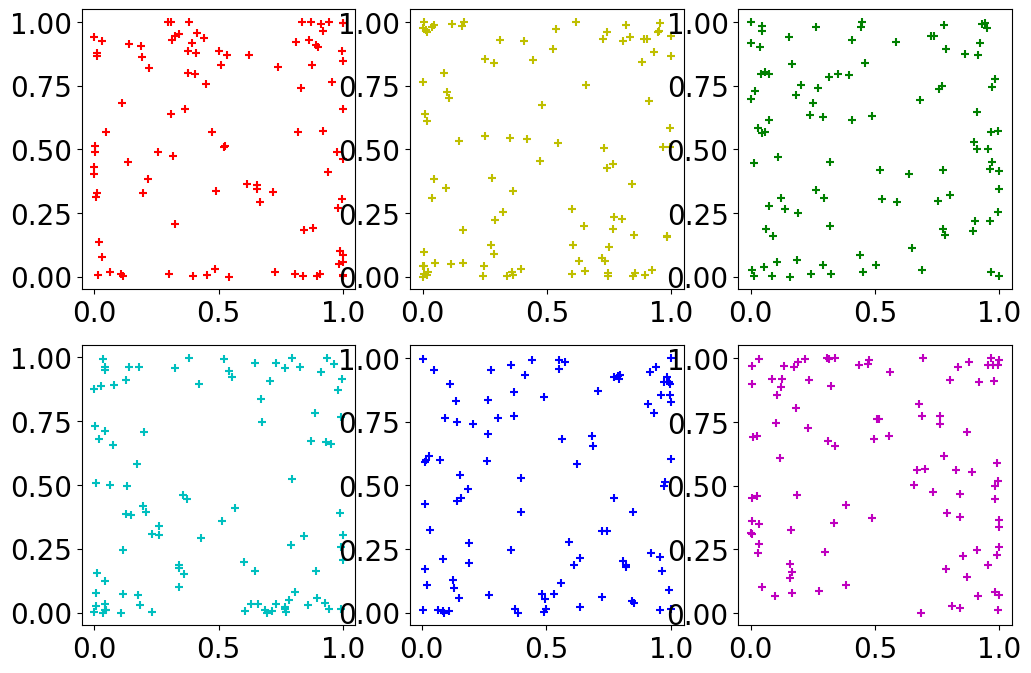

In [13]:
%%time
n_sim_coverage = 1000
n_refs = 100
simulation_indices = [0,1,2,3,4,5,]
# simulations = [samples[i] for i in simulation_indices]
simulation_colors = ['r','y','g','c','b','m','k','k','k']
reference_markers = ['.','x','+','^','o','v','s','D','*','h']
reference_distribution_figure = plt.figure(figsize=(12,8))
for i,_ in enumerate(simulation_indices): reference_distribution_figure.add_subplot(2,3,i+1)
for ri in range(n_refs):
    references,_,_ = R.references2D(samples[-n_sim_coverage:])
    for i,si in enumerate(simulation_indices):
        reference = references[si]
        reference_distribution_figure.axes[i].scatter([reference[0]], [reference[1]],color=simulation_colors[si],marker=reference_markers[2])

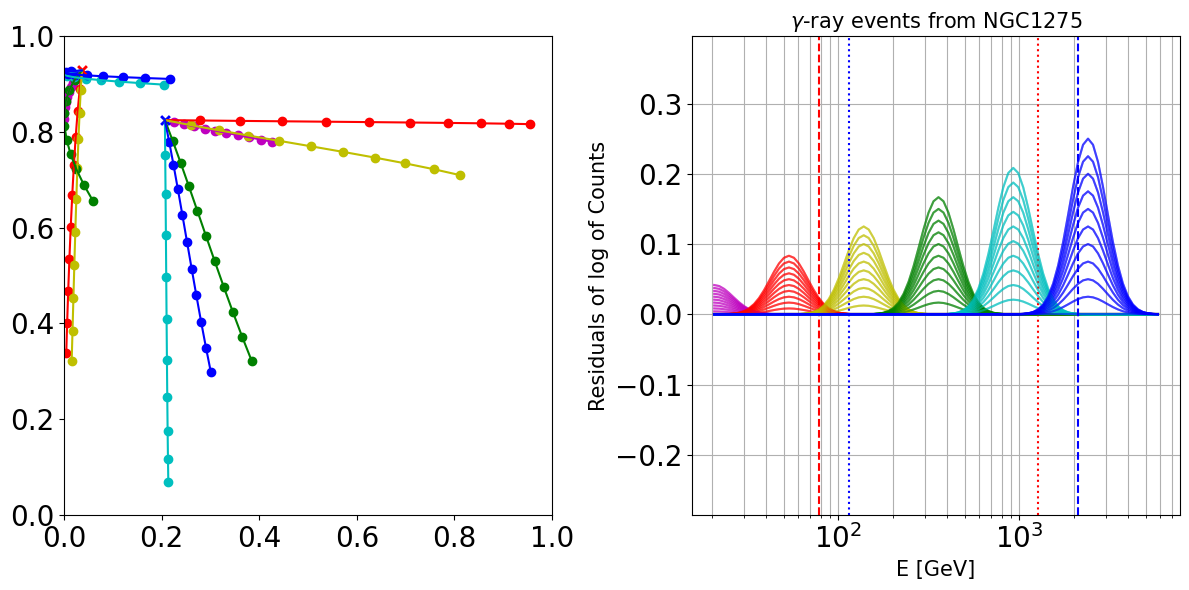

In [14]:
n_sim_coverage = 1000
n_refs = 2
n_central_bins = 6
n_increments = 10
peak_value = 0.25

new_simulation_colors = ['m','r','y', 'g','c','b']
reference_colors = ['r','b']

simulation_length = len(samples['data'][0])
base_simulation = np.zeros(simulation_length)

extended_samples = samples[-n_sim_coverage:]['data'].copy()

reference_path_figure = plt.figure(figsize=(12,6))
reference_path_figure.add_subplot(1,2,1)
reference_path_figure.axes[0].set_xlim([0,1])
reference_path_figure.axes[0].set_ylim([0,1])
reference_path_figure.add_subplot(1,2,2)
reference_path_figure.axes[1].set_ylim(spread_figure.axes[5].get_ylim())
A.configure_plot(legend=False)

for ri in range(n_refs):
    for i in range(n_central_bins):
        gauss_function = norm.pdf(np.arange(0,simulation_length), loc = i*simulation_length/n_central_bins, scale = simulation_length/(4*n_central_bins))
        normed_gauss_function = gauss_function/np.max(gauss_function)
        for j in range(n_increments+1):
            new_simulation = base_simulation + peak_value*j*(i+1)*normed_gauss_function/(n_increments*n_central_bins)
            extended_samples = np.append(extended_samples,[new_simulation],axis=0)
    
    references,_,random_variables = R.references2D(extended_samples)
    
    
    for i in range(n_central_bins):
        reference_path_figure.axes[0].plot(references[n_sim_coverage+i*(n_increments+1):n_sim_coverage+(i+1)*(n_increments+1),0],references[n_sim_coverage+i*(n_increments+1):n_sim_coverage+(i+1)*(n_increments+1),1], color = new_simulation_colors[i])
        reference_path_figure.axes[0].scatter(references[n_sim_coverage+i*(n_increments+1)+1:n_sim_coverage+(i+1)*(n_increments+1),0],references[n_sim_coverage+i*(n_increments+1)+1:n_sim_coverage+(i+1)*(n_increments+1),1], color = new_simulation_colors[i])
        reference_path_figure.axes[0].scatter([references[n_sim_coverage,0]],[references[n_sim_coverage,1]], marker = 'x', color = reference_colors[ri])
        for j in range((n_increments+1)): 
            A.import_counts(obs=extended_samples[n_sim_coverage + i*(n_increments+1)+j])
            A.compute_case(new_fig=0,new_counts=0,plot_obs=1,plot_exp=0,label_exp=0, errorbands=False,
                           transparency=0.5,axes=reference_path_figure.axes[1],color_obs=new_simulation_colors[i],errors=False,label_obs=False)

    reference_path_figure.axes[1].axvline(A.bin_centers[random_variables['range1'][0]],linestyle = '--', color = reference_colors[ri])
    reference_path_figure.axes[1].axvline(A.bin_centers[random_variables['range1'][-1]],linestyle = ':', color = reference_colors[ri])
reference_path_figure.tight_layout()


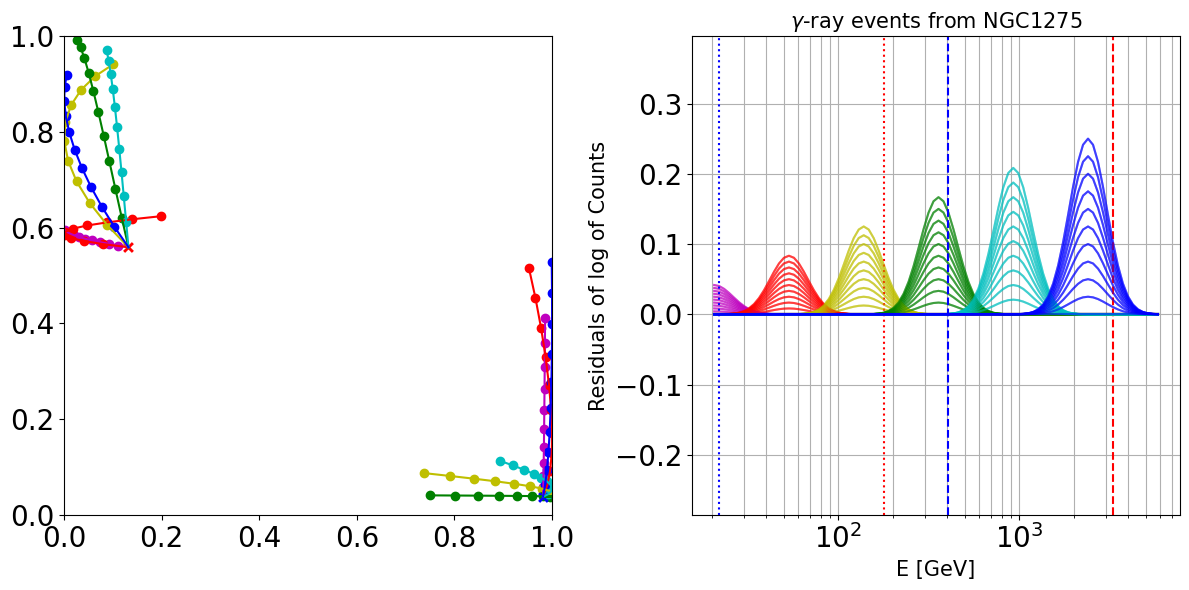

In [15]:
n_sim_coverage = 1000
n_refs = 2
n_central_bins = 6
n_increments = 10
peak_value = 0.25

new_simulation_colors = ['m','r','y', 'g','c','b']

simulation_length = len(samples['data'][0])
base_simulation = np.zeros(simulation_length)

extended_samples = samples[-n_sim_coverage:]['data'].copy()

reference_path_figure = plt.figure(figsize=(12,6))
reference_path_figure.add_subplot(1,2,1)
reference_path_figure.axes[0].set_xlim([0,1])
reference_path_figure.axes[0].set_ylim([0,1])
reference_path_figure.add_subplot(1,2,2)
reference_path_figure.axes[1].set_ylim(spread_figure.axes[5].get_ylim())
A.configure_plot(legend=False)

for ri in range(n_refs):
    for i in range(n_central_bins):
        gauss_function = norm.pdf(np.arange(0,simulation_length), loc = i*simulation_length/n_central_bins, scale = simulation_length/(4*n_central_bins))
        normed_gauss_function = gauss_function/np.max(gauss_function)
        for j in range(n_increments+1):
            new_simulation = base_simulation + peak_value*j*(i+1)*normed_gauss_function/(n_increments*n_central_bins)
            extended_samples = np.append(extended_samples,[new_simulation],axis=0)
    
    references,_,random_variables = R.references2D(extended_samples)
    
    
    for i in range(n_central_bins):
        reference_path_figure.axes[0].plot(references[n_sim_coverage+i*(n_increments+1):n_sim_coverage+(i+1)*(n_increments+1),0],references[n_sim_coverage+i*(n_increments+1):n_sim_coverage+(i+1)*(n_increments+1),1], color = new_simulation_colors[i])
        reference_path_figure.axes[0].scatter(references[n_sim_coverage+i*(n_increments+1)+1:n_sim_coverage+(i+1)*(n_increments+1),0],references[n_sim_coverage+i*(n_increments+1)+1:n_sim_coverage+(i+1)*(n_increments+1),1], color = new_simulation_colors[i])
        reference_path_figure.axes[0].scatter([references[n_sim_coverage,0]],[references[n_sim_coverage,1]], marker = 'x', color = reference_colors[ri])
        for j in range((n_increments+1)): 
            A.import_counts(obs=extended_samples[n_sim_coverage + i*(n_increments+1)+j])
            A.compute_case(new_fig=0,new_counts=0,plot_obs=1,plot_exp=0,label_exp=0, errorbands=False,
                           transparency=0.5,axes=reference_path_figure.axes[1],color_obs=new_simulation_colors[i],errors=False,label_obs=False)

    reference_path_figure.axes[1].axvline(A.bin_centers[random_variables['range1'][0]],linestyle = '--', color = reference_colors[ri])
    reference_path_figure.axes[1].axvline(A.bin_centers[random_variables['range1'][-1]],linestyle = ':', color = reference_colors[ri])
reference_path_figure.tight_layout()


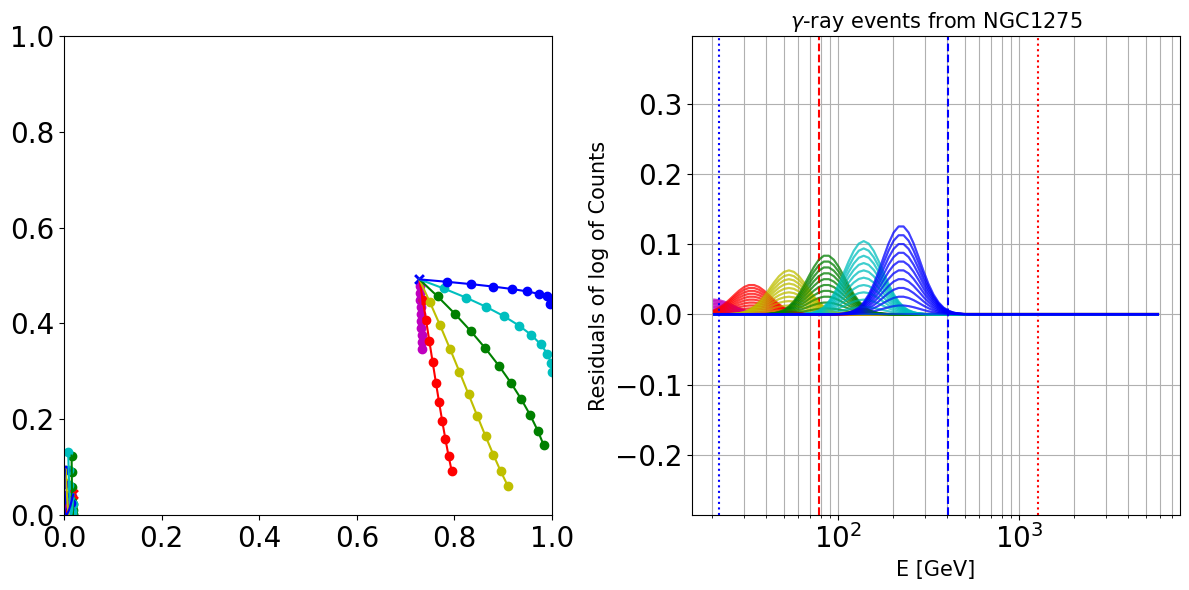

In [16]:
n_sim_coverage = 1000
n_refs = 2
n_central_bins = 6
n_increments = 10
peak_value = 0.25

new_simulation_colors = ['m','r','y', 'g','c','b']
reference_colors = ['r','b']

simulation_length = len(samples['data'][0])
base_simulation = np.zeros(simulation_length)

extended_samples = samples[-n_sim_coverage:]['data'].copy()

reference_path_figure = plt.figure(figsize=(12,6))
reference_path_figure.add_subplot(1,2,1)
reference_path_figure.axes[0].set_xlim([0,1])
reference_path_figure.axes[0].set_ylim([0,1])
reference_path_figure.add_subplot(1,2,2)
reference_path_figure.axes[1].set_ylim(spread_figure.axes[5].get_ylim())
A.configure_plot(legend=False)

tightness = 0.5

for ri in range(n_refs):
    for i in range(n_central_bins):
        gauss_function = norm.pdf(np.arange(0,simulation_length), loc = tightness*i*simulation_length/n_central_bins, scale = simulation_length/(4*n_central_bins))
        normed_gauss_function = gauss_function/np.max(gauss_function)
        for j in range(n_increments+1):
            new_simulation = base_simulation + peak_value*j*(i+1)*tightness*normed_gauss_function/(n_increments*n_central_bins)
            extended_samples = np.append(extended_samples,[new_simulation],axis=0)
    
    references,_,random_variables = R.references2D(extended_samples)
    
    
    for i in range(n_central_bins):
        reference_path_figure.axes[0].plot(references[n_sim_coverage+i*(n_increments+1):n_sim_coverage+(i+1)*(n_increments+1),0],references[n_sim_coverage+i*(n_increments+1):n_sim_coverage+(i+1)*(n_increments+1),1], color = new_simulation_colors[i])
        reference_path_figure.axes[0].scatter(references[n_sim_coverage+i*(n_increments+1)+1:n_sim_coverage+(i+1)*(n_increments+1),0],references[n_sim_coverage+i*(n_increments+1)+1:n_sim_coverage+(i+1)*(n_increments+1),1], color = new_simulation_colors[i])
        reference_path_figure.axes[0].scatter([references[n_sim_coverage,0]],[references[n_sim_coverage,1]], marker = 'x', color = reference_colors[ri])
        for j in range((n_increments+1)): 
            A.import_counts(obs=extended_samples[n_sim_coverage + i*(n_increments+1)+j])
            A.compute_case(new_fig=0,new_counts=0,plot_obs=1,plot_exp=0,label_exp=0, errorbands=False,
                           transparency=0.5,axes=reference_path_figure.axes[1],color_obs=new_simulation_colors[i],errors=False,label_obs=False)

    reference_path_figure.axes[1].axvline(A.bin_centers[random_variables['range1'][0]],linestyle = '--', color = reference_colors[ri])
    reference_path_figure.axes[1].axvline(A.bin_centers[random_variables['range1'][-1]],linestyle = ':', color = reference_colors[ri])
reference_path_figure.tight_layout()
